In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNetCV
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Data**

In [3]:
df=pd.read_csv('/content/drive/MyDrive/aids project/diffractive_events.csv')
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
ndf=pd.read_csv('/content/drive/MyDrive/aids project/non_diffractive_events.csv')
ndf=ndf.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df

,Event,ParticleID,Charged,pT,Eta,Phi,Rapidity,Energy,Class
0,0,211,1,0.467047,-9.51354,0.587825,-9.47077,3162.35000,1
1,0,-211,1,0.380455,9.56740,1.483360,9.50427,2718.57000,1
2,0,211,1,0.468958,-7.45112,2.184270,-7.40868,403.72300,1
3,0,211,1,0.354883,-4.86181,-0.612371,-4.78991,22.93750,1
4,0,211,1,0.074657,-4.18083,-0.540882,-3.43016,2.44658,1
...,...,...,...,...,...,...,...,...,...
324004,4999,22,0,0.087607,-9.87758,-1.559180,-9.87758,853.67000,1
324005,4999,22,0,0.103973,9.04962,2.280840,9.04962,442.68200,1
324006,4999,22,0,0.093608,8.50145,-2.651360,8.50145,230.36400,1
324007,4999,22,0,0.136868,7.67510,2.196870,7.67510,147.41000,1


In [4]:
ndf

,Event,ParticleID,Charged,pT,Eta,Phi,Rapidity,Energy,Class
0,0,211,1,0.411630,6.581580,-2.114280,6.527170,148.533000,0
1,0,-211,1,0.201976,3.204790,1.299400,3.010390,2.497380,0
2,0,-211,1,0.081769,4.313030,0.158239,3.631340,3.056420,0
3,0,211,1,0.713790,3.240200,0.757945,3.221500,9.129710,0
4,0,-321,1,0.303322,8.028550,0.774174,7.381330,465.191000,0
...,...,...,...,...,...,...,...,...,...
552812,4999,22,0,0.252850,-1.289850,0.963092,-1.289850,0.494010,0
552813,4999,22,0,0.079990,-10.106500,1.511430,-10.106500,979.909000,0
552814,4999,22,0,0.054055,-8.913150,-2.889710,-8.913150,200.789000,0
552815,4999,22,0,0.058453,-0.738072,0.713808,-0.738072,0.075110,0


# **Data Preprocessing**


In [5]:
# Function to calculate the derived features for each event
def calculate_event_features(event_group):
    total_multiplicity = len(event_group)
    charged_multiplicity = event_group['Charged'].sum()

    features = {
        'TotalMultiplicity': total_multiplicity,
        'ChargedMultiplicity': charged_multiplicity,
        'ChargeRatio': charged_multiplicity / total_multiplicity if total_multiplicity != 0 else 0,  # New feature
        'Mean_pT': event_group['pT'].mean(),
        'Var_pT': event_group['pT'].var(),
        'Mean_Eta': event_group['Eta'].mean(),
        'Var_Eta': event_group['Eta'].var(),
        'Mean_Phi': event_group['Phi'].mean(),
        'Var_Phi': event_group['Phi'].var(),
        'Mean_Rapidity': event_group['Rapidity'].mean(),
        'Var_Rapidity': event_group['Rapidity'].var(),
        'TotalEnergy': event_group['Energy'].sum(),
        'EnergyRatio': event_group['Energy'].max() / event_group['Energy'].sum() if event_group['Energy'].sum() != 0 else 0,
        'AngularCorrelation': event_group['Phi'].corr(event_group['Eta']),
        'Class': event_group['Class'].iloc[0]  # Assuming Class is the same for all particles in an event
    }
    return pd.Series(features)

# Group by the 'Event' column and calculate features
df = df.groupby('Event').apply(calculate_event_features).reset_index()
ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()

# Display the resulting DataFrame
df


<ipython-input-5-0de011c5657f>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Event').apply(calculate_event_features).reset_index()
<ipython-input-5-0de011c5657f>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()


,Event,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,TotalEnergy,EnergyRatio,AngularCorrelation,Class
0,0,52.0,30.0,0.576923,0.270898,0.035353,-4.170909,16.006550,-0.254531,2.861754,-4.017747,15.138394,13999.997705,0.276127,0.065435,1.0
1,1,23.0,12.0,0.521739,0.239540,0.026703,-6.019059,15.964029,0.282267,4.647811,-5.925008,12.785648,13999.997850,0.499999,-0.196228,1.0
2,2,69.0,34.0,0.492754,0.311305,0.049968,0.429145,29.380898,0.099079,3.161140,0.374890,26.748725,14000.001283,0.219479,-0.099422,1.0
3,3,6.0,4.0,0.666667,0.243757,0.022484,5.603912,73.260949,1.384170,2.878318,5.652828,56.740534,14000.009000,0.500000,-0.246380,1.0
4,4,23.0,12.0,0.521739,0.307067,0.067781,5.472527,26.682963,-0.072966,4.290823,5.321094,23.850245,13999.996902,0.381715,-0.221634,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,25.0,10.0,0.400000,0.276992,0.058526,5.914692,15.043444,-0.139713,3.736033,5.884456,13.091383,13999.996790,0.499999,-0.147230,1.0
4996,4996,12.0,4.0,0.333333,0.226454,0.034313,-6.135848,29.898386,0.112974,3.185457,-6.092122,26.690955,14000.002640,0.500000,-0.361007,1.0
4997,4997,53.0,30.0,0.566038,0.334502,0.067613,-3.621986,10.435548,-0.297487,3.215061,-3.502249,9.341667,14000.004057,0.499845,0.082215,1.0
4998,4998,70.0,40.0,0.571429,0.266811,0.036833,1.607176,17.948641,-0.233336,3.113589,1.676422,15.877155,13999.998614,0.496734,0.189569,1.0


In [6]:
data=pd.concat([df,ndf])
data = data.sample(frac=1).reset_index(drop=True)
data = data.drop(['Event', 'TotalEnergy'], axis=1)
data

,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,EnergyRatio,AngularCorrelation,Class
0,59.0,32.0,0.542373,0.320772,0.062854,3.446848,9.330779,0.308674,3.040301,3.315043,8.160389,0.499922,-0.155246,1.0
1,89.0,38.0,0.426966,0.293521,0.051626,-0.822177,24.772436,0.024683,3.360322,-0.809352,23.054241,0.170557,0.004542,0.0
2,29.0,16.0,0.551724,0.337849,0.050759,-4.386257,14.147999,0.217347,4.296396,-4.135029,12.285225,0.499975,0.112699,1.0
3,88.0,40.0,0.454545,0.295790,0.045388,0.433851,26.587437,0.225767,3.195470,0.409878,25.116912,0.278704,-0.054268,0.0
4,148.0,58.0,0.391892,0.370709,0.136758,-1.512889,11.492363,-0.099291,3.298917,-1.455505,10.939512,0.286726,-0.052314,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,91.0,46.0,0.505495,0.342479,0.059524,-1.981992,14.602035,-0.338423,3.125652,-1.870700,13.537983,0.359630,0.094864,1.0
9996,62.0,28.0,0.451613,0.276703,0.035336,3.669758,10.888973,-0.064950,3.228327,3.578285,10.160089,0.499908,-0.107796,1.0
9997,90.0,36.0,0.400000,0.340691,0.122955,-2.358590,12.453179,-0.026059,3.262747,-2.271049,11.113694,0.497878,0.136807,1.0
9998,83.0,40.0,0.481928,0.331322,0.066225,0.641053,25.204755,0.057706,3.501563,0.634829,23.164782,0.272232,0.124946,0.0


In [7]:
X = data.drop('Class', axis=1)  # Features are all columns except 'class'
y = data['Class']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, y, test_size=0.2, random_state=42)

# **Feature Selection**

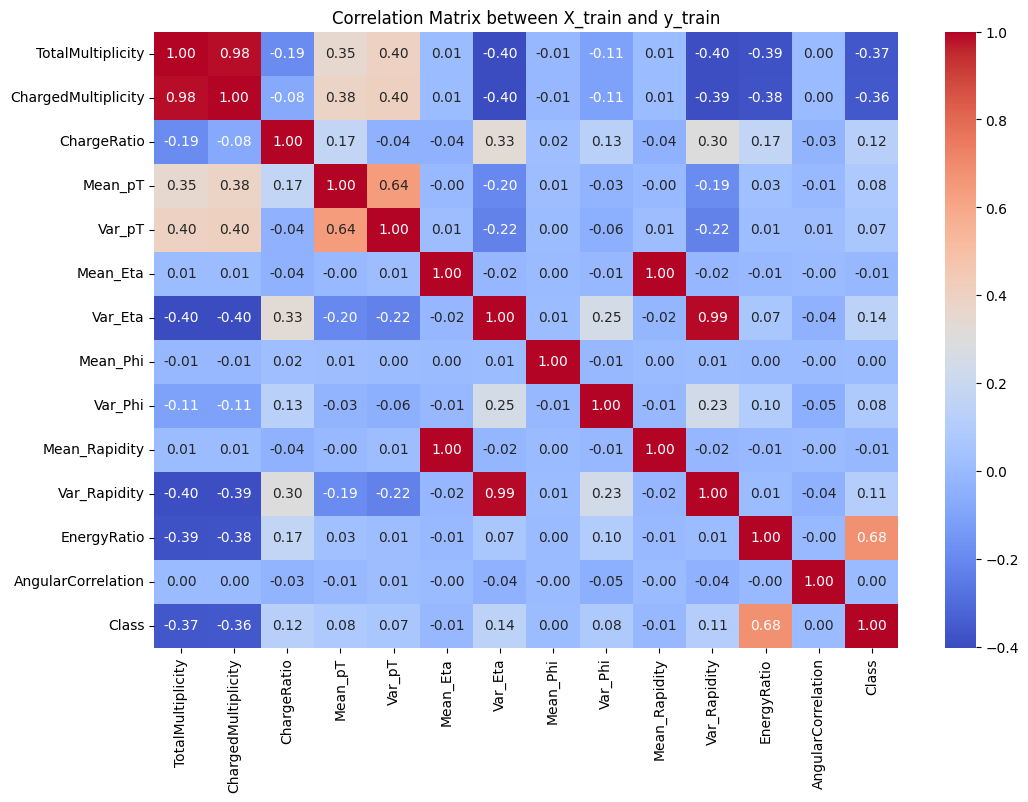

In [8]:
data_combined = pd.concat([X_train, y_train], axis=1)

# Compute correlation matrix
correlation_matrix = data_combined.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between X_train and y_train")
plt.show()

In [9]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Get feature importance
importance = xgb_clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
11          EnergyRatio    0.395056
0     TotalMultiplicity    0.177350
1   ChargedMultiplicity    0.087298
5              Mean_Eta    0.077363
10         Var_Rapidity    0.073847
6               Var_Eta    0.054013
9         Mean_Rapidity    0.035093
4                Var_pT    0.025048
3               Mean_pT    0.021730
12   AngularCorrelation    0.014163
8               Var_Phi    0.014157
7              Mean_Phi    0.013509
2           ChargeRatio    0.011372


In [10]:
# Train a Random Forest classifier with RFE
estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=5, step=1)  # Select top 5 features
selector = selector.fit(X_train, y_train)

# Print selected features
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['TotalMultiplicity', 'ChargedMultiplicity', 'Mean_Eta', 'Var_Rapidity',
       'EnergyRatio'],
      dtype='object')


 99%|===================| 7940/8000 [00:45<00:00]       

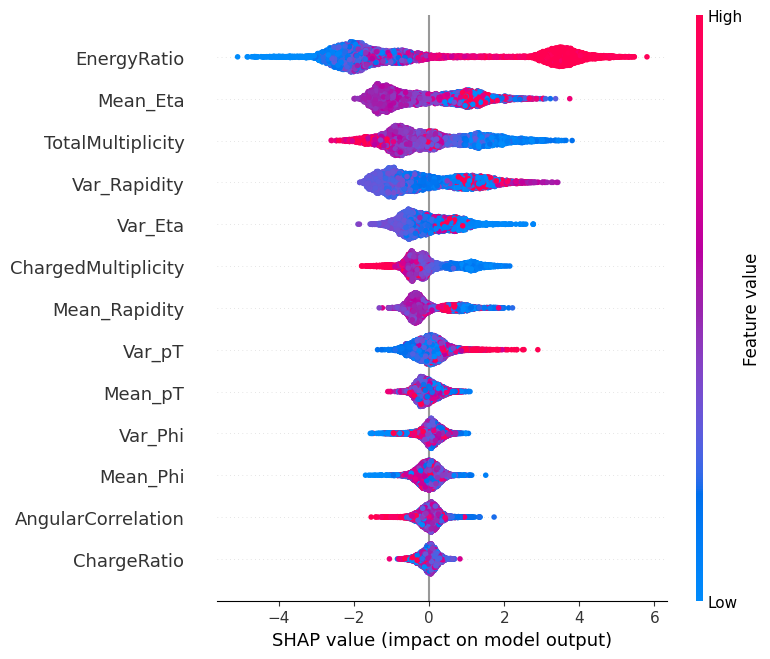

In [12]:
model = XGBClassifier()  # or any trained model
model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)  # Feature importance summary


In [13]:
X_train=X_train[['TotalMultiplicity', 'ChargedMultiplicity', 'Mean_Eta', 'Var_Rapidity',
'EnergyRatio']]
X_test=X_test[['TotalMultiplicity', 'ChargedMultiplicity', 'Mean_Eta', 'Var_Rapidity',
'EnergyRatio']]

## **Random Forest**

In [14]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',       # Scoring metric for evaluation
    cv=3,                     # 3-fold cross-validation (reduce folds)
    verbose=1,                # Show progress during grid search
    n_jobs=-1                 # Use all available cores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 91.25%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      1008
         1.0       0.93      0.89      0.91       992

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



# **XGBoost**

In [15]:
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Accuracy: 91.50%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1008
         1.0       0.94      0.88      0.91       992

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.91      2000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **Support Vector Machines**

In [16]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4],
    'coef0': [0.0, 0.1],
    'class_weight': [None, 'balanced']
}

# Initialize the SVM classifier
svm_model = SVC(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'C': 10, 'class_weight': None, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 91.95%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      1008
         1.0       0.95      0.88      0.92       992

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# **MLP Neural Network**

In [17]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50)],  # Single and multi-layer configurations
    'activation': ['relu'],  # Most common activation
    'solver': ['adam'],  # Adam optimizers
    'alpha': [0.001, 0.01],  # Regularization strength
    'learning_rate': ['adaptive'],  # Types of learning rate schedules
    'max_iter': [300]  # Number of iterations
}


# Initialize the MLP classifier
mlp_model = MLPClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_mlp_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'adam'}
Accuracy: 92.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1008
         1.0       0.94      0.89      0.92       992

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# **Introducing a New Feature: Rapidity Gap**

In [18]:
df=pd.read_csv('/content/drive/MyDrive/aids project/diffractive_events.csv')
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
ndf=pd.read_csv('/content/drive/MyDrive/aids project/non_diffractive_events.csv')
ndf=ndf.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# Function to calculate the derived features for each event, including MaxRapidityGap
def calculate_event_features(event_group):
    total_multiplicity = len(event_group)
    charged_multiplicity = event_group['Charged'].sum()

    # Calculate the MaxRapidityGap (max gap between consecutive rapidities)
    rapidities = event_group['Rapidity'].sort_values().tolist()  # Sort rapidities in ascending order
    max_rapidity_gap = 0
    if len(rapidities) > 1:
        # Calculate the gaps between consecutive rapidities
        for i in range(len(rapidities) - 1):
            gap = rapidities[i + 1] - rapidities[i]
            if gap > max_rapidity_gap:
                max_rapidity_gap = gap

    features = {
        'TotalMultiplicity': total_multiplicity,
        'ChargedMultiplicity': charged_multiplicity,
        'ChargeRatio': charged_multiplicity / total_multiplicity if total_multiplicity != 0 else 0,  # New feature
        'Mean_pT': event_group['pT'].mean(),
        'Var_pT': event_group['pT'].var(),
        'Mean_Eta': event_group['Eta'].mean(),
        'Var_Eta': event_group['Eta'].var(),
        'Mean_Phi': event_group['Phi'].mean(),
        'Var_Phi': event_group['Phi'].var(),
        'Mean_Rapidity': event_group['Rapidity'].mean(),
        'Var_Rapidity': event_group['Rapidity'].var(),
        'TotalEnergy': event_group['Energy'].sum(),
        'EnergyRatio': event_group['Energy'].max() / event_group['Energy'].sum() if event_group['Energy'].sum() != 0 else 0,
        'AngularCorrelation': event_group['Phi'].corr(event_group['Eta']),
        'MaxRapidityGap': max_rapidity_gap,  # New feature
        'Class': event_group['Class'].iloc[0]  # Assuming Class is the same for all particles in an event
    }
    return pd.Series(features)

# Group by the 'Event' column and calculate features
df = df.groupby('Event').apply(calculate_event_features).reset_index()
ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()

data=pd.concat([df,ndf])
data = data.sample(frac=1).reset_index(drop=True)
data = data.drop(['Event', 'TotalEnergy'], axis=1)
data



<ipython-input-18-e63e72cd7d1c>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Event').apply(calculate_event_features).reset_index()
<ipython-input-18-e63e72cd7d1c>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()


,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,EnergyRatio,AngularCorrelation,MaxRapidityGap,Class
0,83.0,40.0,0.481928,0.272684,0.054423,0.734601,29.051846,0.106939,3.312149,0.614440,26.693209,0.154275,-0.008288,1.090520,0.0
1,25.0,8.0,0.320000,0.209171,0.039160,6.591528,16.625179,-0.276275,3.700303,6.441306,13.131939,0.499999,-0.111070,14.079840,1.0
2,19.0,12.0,0.631579,0.329122,0.038670,4.252575,20.473369,0.277930,3.500561,4.104077,18.483142,0.499978,0.371041,9.745504,1.0
3,41.0,22.0,0.536585,0.364085,0.102369,-4.506113,16.485286,-0.125972,3.425580,-4.316189,13.642135,0.468113,0.279929,9.376890,1.0
4,60.0,26.0,0.433333,0.267604,0.040564,4.395626,10.086184,-0.131287,3.104577,4.182667,9.061857,0.499905,0.133697,8.413520,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,85.0,38.0,0.447059,0.274854,0.054360,-0.297385,28.627361,-0.164005,3.753790,-0.367430,26.122848,0.159495,-0.004087,1.020890,0.0
9996,48.0,26.0,0.541667,0.263901,0.042426,3.763621,12.057309,0.019187,2.774176,3.563917,11.625673,0.499869,0.017209,9.022584,1.0
9997,101.0,52.0,0.514851,0.238518,0.034572,-0.055740,32.620714,-0.006077,3.544182,0.042737,29.672570,0.189902,-0.128461,1.496920,0.0
9998,8.0,6.0,0.750000,0.266155,0.031653,2.668121,75.048686,-0.179044,2.438270,2.546486,69.288474,0.486820,0.270848,11.825750,1.0


In [19]:
X = data.drop('Class', axis=1)  # Features are all columns except 'class'
y = data['Class']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, y, test_size=0.2, random_state=42)

In [20]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Get feature importance
importance = xgb_clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
13       MaxRapidityGap    0.758851
11          EnergyRatio    0.029028
4                Var_pT    0.025028
10         Var_Rapidity    0.025007
6               Var_Eta    0.020980
1   ChargedMultiplicity    0.019425
3               Mean_pT    0.018843
0     TotalMultiplicity    0.018451
2           ChargeRatio    0.014999
12   AngularCorrelation    0.014714
5              Mean_Eta    0.014630
9         Mean_Rapidity    0.014034
7              Mean_Phi    0.013256
8               Var_Phi    0.012755


In [21]:
X_train=X_train[['MaxRapidityGap']]
X_test=X_test[['MaxRapidityGap']]

In [22]:
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Accuracy: 94.60%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       997
         1.0       0.97      0.92      0.94      1003

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:04:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
